# Challenge: Get the best results on the [fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset!

> "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."

<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png">




## TASK - Challenge: Get the best results on the fashionMNIST dataset!

The challenge of this task is to get the best results on the fashionMNIST dataset by tuning hyperparameters of the model and observing convergence behavior.

"Best" - for simplicity - means the highest accuracy on the validation set.

"Rules":

    You can change any hyperparameters,
    including the number of layers,
    width of the layers,
    activation functions,
    regularizers (and their parameters),
    optimizer (and it's parameters), but
    you should not change the model architecture, use only fully connected layers! (Even if you know any others... :-P

Added constraint: The model with the "best performance" has to be saved, so it should not be just a printout happening once during training!

And: You may NOT manipulate the validation set! :-P

Happy coding! :-)


# Loading the data

In [ ]:
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2022-05-08 14:52:20--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.132
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.171.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  14.7MB/s    in 1.7s    

2022-05-08 14:52:22 (14.7 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2022-05-08 14:52:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.132
Connecting to fashion-mnist.s3-website.eu-central-1.a

In [14]:
import numpy as np
import os
import gzip

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [15]:
train_images, train_labels = load_mnist('.')
# because of some limitations of Keras's softmax implementation, it's 
# advisable to normalise the images by dividing the intensities by the
# maximal 255 value
train_images = train_images / 255.

valid_test_images, valid_test_labels = load_mnist('.', 't10k')

valid_test_images = valid_test_images / 255. # the same normalization for valid and test

valid_images = valid_test_images[:5000]
valid_labels = valid_test_labels[:5000]
test_images = valid_test_images[5000:]
test_labels = valid_test_labels[5000:]

print(train_images.shape, valid_images.shape, test_images.shape)

(60000, 784) (5000, 784) (5000, 784)


Let's have a look at the first few training images:

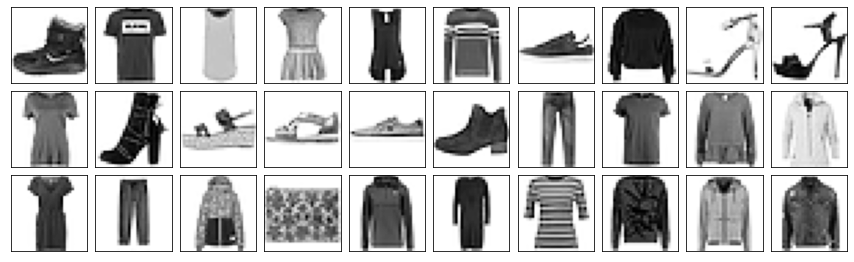

In [16]:
from matplotlib import pyplot as plt
from math import ceil

def show_images(images):
    """Show images in a grid
    """
    n_rows = ceil(len(images) / 10)
    fig, ax = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, _ in enumerate(images):
        # below we scale back the intensities to display the images correctly
        ax[i // 10, i % 10].imshow(255 * images[i].reshape(28, 28), cmap='Greys')

show_images(train_images[:30])
plt.show();

# Model

## Preliminaries

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping


We set the random seeds to get (as far as possible) reproducible results:

In [18]:
# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(14)
tf.random.set_seed(19)

## Hyperparameters

In [31]:
# Task parameters

input_size = 784
n_classes = 10

# Hyperparameters
#################

# batch_size = 20
# epochs = 10


# dropout??? or no dropout???
# dropout_rate = ???
# dropout_rate = 0.1

# regularization

lambda_ = 0.0001
regularizer = l1(lambda_)

# weight initialization
# initializer = #???

kernel_initializer='random_normal'

##########
# Warning! 
##########
# Possible bug in Keras Initalizers!
# When stuck, use RandomUniform or RandomNormal!

# Model parameters
#################

# hidden_layers = 2
hidden_layer_size = 400
n_hidden_layers = 4
hidden_layer_sizes = n_hidden_layers * [hidden_layer_size]


# activation function
activation = 'relu' #'relu', 'sigmoid', 'hard_sigmoid', 'linear'
# activation_fun =  #???


## Network

In [32]:
tf.compat.v1.reset_default_graph() # It's good practice to clean and reset everything
clear_session            # even using Keras

# Model
#######

input_layer= Input(shape=(784,))

#Define input with input_size (achtung, vector! :-)


# Hidden layers

cur_last_layer = input_layer

# Construct a for loop going over the values of hidden_layer_sizes
# using cur_last_layer as pointer
# build up the network layer by layer
# use the parameters units, activation, kernel_regularizer, kernel_initializer, bias_initializer
# Add a dopout layer after each one WHEN PARAMETER SET!
# Remember, dropout is a separate layer, use dropout_rate as parameter


for x in range(n_hidden_layers):
  cur_last_layer = Dense(hidden_layer_size, 
                       activation=activation)(cur_last_layer)

  drop_layer = Dropout(rate = dropout_rate)(cur_last_layer)
  cur_last_layer = drop_layer


output = Dense(10, activation='softmax')(cur_last_layer)
model = Model(inputs=input_layer, outputs=output)

# Softmax 
#Define the predictions!
#Use Softmax!
# predictions = 'softmax'

# Full model
# Instantiate with input and output
# model = ...

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 400)               314000    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               160400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               160400    
                                                                 
 dropout_2 (Dropout)         (None, 400)               0     

In [45]:
# Loss 

loss = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adam(learning_rate=0.0007) #??? some SGD variant 

 
# Compilation
#############
#Compile with optimizer and loss, use accuracy as metric
metrics=['accuracy']

In [46]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Loss, optimization and compilation

In [48]:
history = model.fit(x=train_images, y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=27,
                    batch_size=168)

Epoch 1/27
358/358 [==============================] - 2s 7ms/step - loss: 0.0501 - accuracy: 0.9828 - val_loss: 0.7010 - val_accuracy: 0.9014
Epoch 2/27
358/358 [==============================] - 2s 6ms/step - loss: 0.0498 - accuracy: 0.9821 - val_loss: 0.6473 - val_accuracy: 0.9018
Epoch 3/27
358/358 [==============================] - 2s 6ms/step - loss: 0.0461 - accuracy: 0.9832 - val_loss: 0.5949 - val_accuracy: 0.9022
Epoch 4/27
358/358 [==============================] - 2s 6ms/step - loss: 0.0435 - accuracy: 0.9843 - val_loss: 0.6753 - val_accuracy: 0.9006
Epoch 5/27
358/358 [==============================] - 2s 6ms/step - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.6570 - val_accuracy: 0.8968
Epoch 6/27
358/358 [==============================] - 2s 6ms/step - loss: 0.0452 - accuracy: 0.9838 - val_loss: 0.6115 - val_accuracy: 0.9024
Epoch 7/27
358/358 [==============================] - 2s 6ms/step - loss: 0.0425 - accuracy: 0.9853 - val_loss: 0.6690 - val_accuracy: 0.8968
Epoch 

In [49]:
acc, loss= model.evaluate(valid_images, valid_labels)

157/157 [==============================] - 1s 3ms/step - loss: 0.6526 - accuracy: 0.9004


## Training

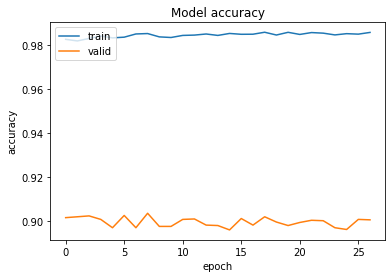

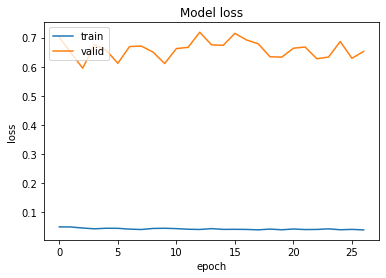

In [50]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
#If you need...
display_history(history)

In [51]:
# Get over this - minimally!!!!!
assert max(history.history['accuracy'])>0.72
assert max(history.history['val_accuracy'])>0.73

## Saving the model

In [52]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
